In [1]:
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from datetime import datetime,timedelta
import datetime
import urllib.request, json 
%matplotlib inline

In [2]:
df = pd.read_json('http://bcmt.taihuynh.info/data.ml.php?n=test1')
df

,Date,Close,symbol,TimeseriesGenerator_length,forecast_periods,model_activation,batch_size,compile_optimizer,optimizer_loss,epochs,new_day_start,new_day_end,selected_interval
0,2021-01-15 09:30:00,26.059999,PLTR,4,20,tanh,1,adam,mse,10,09:50,10:10,1m
1,2021-01-15 09:31:00,26.658600,PLTR,4,20,tanh,1,adam,mse,10,09:50,10:10,1m
2,2021-01-15 09:32:00,26.530001,PLTR,4,20,tanh,1,adam,mse,10,09:50,10:10,1m
3,2021-01-15 09:33:00,26.330000,PLTR,4,20,tanh,1,adam,mse,10,09:50,10:10,1m
4,2021-01-15 09:34:00,26.346901,PLTR,4,20,tanh,1,adam,mse,10,09:50,10:10,1m
...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,2021-01-15 15:55:00,25.600000,PLTR,4,20,tanh,1,adam,mse,10,09:50,10:10,1m
386,2021-01-15 15:56:00,25.628700,PLTR,4,20,tanh,1,adam,mse,10,09:50,10:10,1m
387,2021-01-15 15:57:00,25.603001,PLTR,4,20,tanh,1,adam,mse,10,09:50,10:10,1m
388,2021-01-15 15:58:00,25.520000,PLTR,4,20,tanh,1,adam,mse,10,09:50,10:10,1m


In [3]:
last_day = df["Date"].iloc[-1]
get_day = last_day.date()
get_time= datetime.datetime.strptime('0930','%H%M').time()
complete_day= datetime.datetime.combine(get_day, get_time)
idx = df[df['Date']==complete_day].index.values
idx = idx[0].astype(int)
df.set_index('Date',inplace=True)

In [4]:
optimizer = df['compile_optimizer'][0]
length = df['TimeseriesGenerator_length'][0]
activation = df['model_activation'][0]
batch_size = df['batch_size'][0]
loss = df['optimizer_loss'][0]
epochs= df['epochs'][0]
periods = df['forecast_periods'][0]
activation = df['model_activation'][0]
new_day_plus = df['new_day_start'][0]

In [5]:
df_train = df.drop(columns=['symbol', 'TimeseriesGenerator_length', 'model_activation', 'batch_size','compile_optimizer','optimizer_loss','epochs','forecast_periods','new_day_start','new_day_end','selected_interval'])
df_train_new = df_train.iloc[:idx + 10]
df_train_new

,Close
Date,
2021-01-15 09:30:00,26.059999
2021-01-15 09:31:00,26.658600
2021-01-15 09:32:00,26.530001
2021-01-15 09:33:00,26.330000
2021-01-15 09:34:00,26.346901
2021-01-15 09:35:00,26.750000
2021-01-15 09:36:00,27.105000
2021-01-15 09:37:00,27.177401
2021-01-15 09:38:00,27.379000


In [6]:
scaler = MinMaxScaler()
scaled_full_data = scaler.fit_transform(df_train_new)

In [7]:
n_features = 1

In [8]:
random.seed(10)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=batch_size)

In [9]:
random.seed(10)
model = Sequential()
model.add(LSTM(100,activation=activation,input_shape=(length,n_features),return_sequences=True))
model.add(LSTM(50,activation=activation,return_sequences=True ))
model.add(LSTM(10,activation=activation))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss=loss)
model.fit(generator,epochs=epochs)

Epoch 1/10
6/6 [==============================] - 0s 5ms/step - loss: 0.4639
Epoch 2/10
6/6 [==============================] - 0s 5ms/step - loss: 0.3212
Epoch 3/10
6/6 [==============================] - 0s 5ms/step - loss: 0.1753
Epoch 4/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0872
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0718
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0624
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0566
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0624
Epoch 9/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0613
Epoch 10/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0574


In [10]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
      
    current_pred = model.predict(current_batch)[0]
    

    forecast.append(current_pred) 
    
  
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [11]:
forecast = scaler.inverse_transform(forecast)

In [12]:
last_day = last_day.date()
last_day = last_day.strftime("%m/%d/%Y")

In [13]:
new_day = datetime.datetime.strptime(last_day, '%m/%d/%Y') + datetime.timedelta(days=1)
new_day= new_day.strftime('%m-%d-%Y')

In [14]:
new_day = new_day + ' ' + new_day_plus
forecast_index = pd.date_range(start=new_day,periods=periods,freq='T')
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])
forecast_df

,Forecast
2021-01-16 09:50:00,27.318344
2021-01-16 09:51:00,27.345634
2021-01-16 09:52:00,27.360551
2021-01-16 09:53:00,27.313965
2021-01-16 09:54:00,27.411745
2021-01-16 09:55:00,27.419982
2021-01-16 09:56:00,27.424748
2021-01-16 09:57:00,27.429652
2021-01-16 09:58:00,27.455578
2021-01-16 09:59:00,27.459479


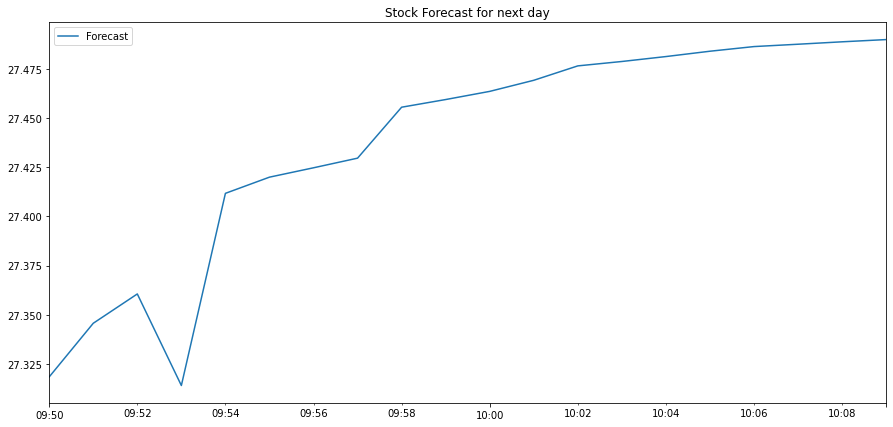

In [15]:
forecast_df.plot(title='Stock Forecast for next day', figsize=(15,7)).get_figure().savefig('output_1.png')